In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
 %reload_ext autoreload

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [4]:
from src.reg_classifier import *

In [5]:
df = pd.read_csv('./data/AB_NYC_2019_EDA.csv').drop(['Unnamed: 0'], axis=1)

target_name = 'price'

In [6]:
X, y = df.drop(columns=[target_name]), df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Test ClassRegressor

In [7]:
df.head()

,neighbourhood,price,availability_365,n-hood_group_Brooklyn,n-hood_group_Manhattan,n-hood_group_Queens,n-hood_group_Staten Island,room_type_Private room,room_type_Shared room,Manh_dist,Broo_dist,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,log_calculated_host_listings_count
0,92.669640,149,365,1,0,0,0,1,0,0.133675,0.025206,0.693147,2.302585,-1.560648,1.791759
1,252.614598,225,355,0,1,0,0,0,0,0.032827,0.108917,0.693147,3.828641,-0.967584,0.693147
2,109.915169,150,365,0,1,0,0,1,0,0.036737,0.158162,1.386294,0.000000,-0.328504,0.000000
3,140.791735,89,194,1,0,0,0,0,0,0.096037,0.036351,0.693147,5.602119,1.534714,0.000000
4,121.010757,80,0,0,1,0,0,0,0,0.027858,0.147596,2.397895,2.302585,-2.302585,0.000000


<AxesSubplot:>

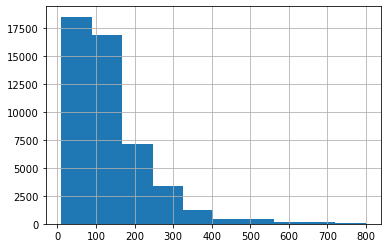

In [8]:
y.hist()

In [9]:
df[target_name].describe()

count    48410.000000
mean       137.575170
std        103.780081
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max        799.000000
Name: price, dtype: float64

In [10]:
clf_perc = ClassRegressor(n_bins=2, bins_calc_method='equal')
clf_perc.fit(X, y)

clf_perc.bin_borders

{0: [10.0, 404.5], 1: [404.5, 799.0]}

In [11]:
pd.Series(clf_perc.y_classes).value_counts()

0    47126
1     1284
dtype: int64

In [12]:
pd.Series(clf_perc.predict(X, regression=True)).value_counts()

207.25    48400
601.75       10
dtype: int64

In [13]:
clf = ClassRegressor(n_bins=2)
clf.fit(X_train_scaled, y_train)

pred_train = clf.predict(X_train_scaled, regression=True)
pred_test = clf.predict(X_test_scaled, regression=True)

print('Class regressor')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Class regressor
train mae 107.4372842092838
test mae 106.63263444191972


<AxesSubplot:>

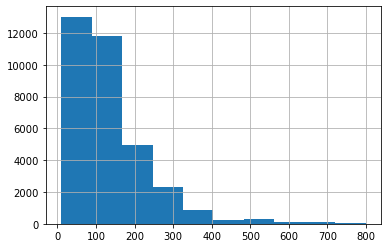

In [14]:
y_train.hist()

<AxesSubplot:>

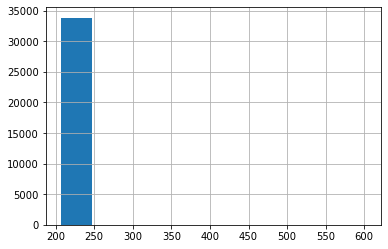

In [15]:
pd.Series(pred_train).hist()

In [16]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_scaled, y_train)


pred_train = dummy_regr.predict(X_train_scaled)
pred_test = dummy_regr.predict(X_test_scaled)

print('Dummy regressor')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Dummy regressor
train mae 73.40003703765083
test mae 73.39060713427676


# Test ClassRegressorEnsemble (with LinearRegression)

In [17]:
N_BINS = 2
N_LEVELS = 1

class_reg = ClassRegressorEnsemble(n_bins=N_BINS, n_levels=N_LEVELS, leaf_model=LinearRegression)

class_reg.fit(X_train_scaled, y_train)

In [18]:
class_reg.models

{(0, (0,)): <src.reg_classifier.ClassRegressor at 0x1b3fd0eee80>}

In [19]:
class_reg.models[(0, (0,))].bin_borders

{0: [9.9999999999, 404.5], 1: [404.4999999999, 799.0]}

In [20]:
#class_reg.models[(1, (0, 0))].bin_borders

In [21]:
#class_reg.models[(1, (0, 1))].bin_borders

In [22]:
X_train_scaled.iloc[0], y_train.iloc[0]

(neighbourhood                         2.390667
 availability_365                      0.804064
 n-hood_group_Brooklyn                -0.834955
 n-hood_group_Manhattan                1.123723
 n-hood_group_Queens                  -0.364281
 n-hood_group_Staten Island           -0.088610
 room_type_Private room               -0.925042
 room_type_Shared room                -0.156487
 Manh_dist                            -1.076243
 Broo_dist                             0.198089
 log_minimum_nights                    0.128277
 log_number_of_reviews                -0.838499
 log_reviews_per_month                -0.036852
 log_calculated_host_listings_count    1.449238
 Name: 0, dtype: float64,
 419)

In [23]:
class_reg.models[(0, (0,))].predict(X_train_scaled.iloc[:1])

array([0], dtype=int64)

In [24]:
class_reg.predict(X_train_scaled.iloc[:1])

array([248.29169184])

<AxesSubplot:>

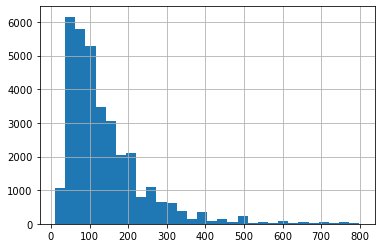

In [25]:
y_train.hist(bins=30)

<AxesSubplot:>

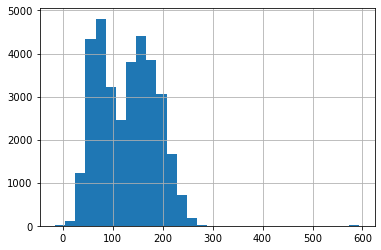

In [26]:
pred_train = class_reg.predict(X_train_scaled)
pd.Series(pred_train).hist(bins=30)

In [27]:
class_reg = ClassRegressorEnsemble(n_bins=N_BINS, n_levels=N_LEVELS, leaf_model=LinearRegression)
class_reg.fit(X_train_scaled, y_train)

pred_train = class_reg.predict(X_train_scaled)
pred_test = class_reg.predict(X_test_scaled)

print('Simple ClassRegressor ensemble')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Simple ClassRegressor ensemble
train mae 47.43186437041619
test mae 47.21950775279553


In [28]:
class_reg = ClassRegressorEnsemble(n_bins=100, n_levels=1, leaf_model=None)
class_reg.fit(X_train_scaled, y_train)

pred_train = class_reg.predict(X_train_scaled)
pred_test = class_reg.predict(X_test_scaled)

print('Simple ClassRegressor ensemble')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Simple ClassRegressor ensemble
train mae 47.95158984272065
test mae 48.348871101020585
